In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 基本套件
import numpy as np
import pandas as pd
import os

# 資料前處理
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# tensorflow, keras相關套件
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.layers import Bidirectional, LSTM, Dropout, Dense, Activation, SeparableConv1D, LayerNormalization, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import CosineDecay

# 資料視覺化
import seaborn as sns
import matplotlib.pyplot as plt

os.getcwd()

'/content'

## Data

In [3]:
# Load training data
train_df = pd.read_csv('/content/drive/My Drive/train.csv')
print('View the data shape', train_df.shape)
# train_df.head()

View the data shape (20631, 27)


In [4]:
# Load test data
test_df = pd.read_csv('/content/drive/My Drive/test.csv')
print('View the data shape', test_df.shape)
# test_df.head()

View the data shape (12680, 26)


EWMA

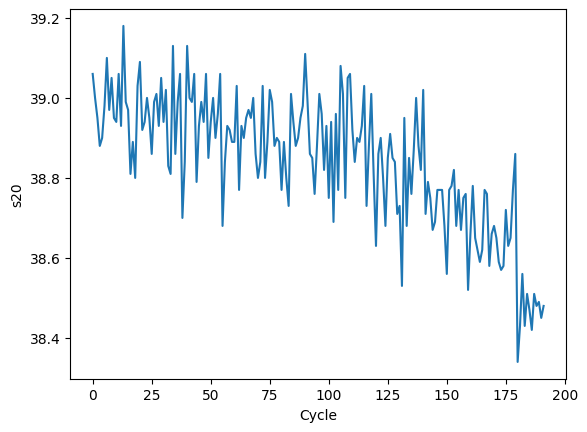

In [ ]:
plt.plot(train_df[train_df['id']==1]['s20'])
plt.xlabel('Cycle')
plt.ylabel('s20')
plt.show()

In [ ]:
features_to_smoothing = ['setting1','setting2','s2', 's3', 's4','s6','s7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
train_df[features_to_smoothing] = train_df.groupby('id')[features_to_smoothing].apply(lambda x: x.ewm(alpha=0.4).mean()).reset_index(level=0, drop=True)

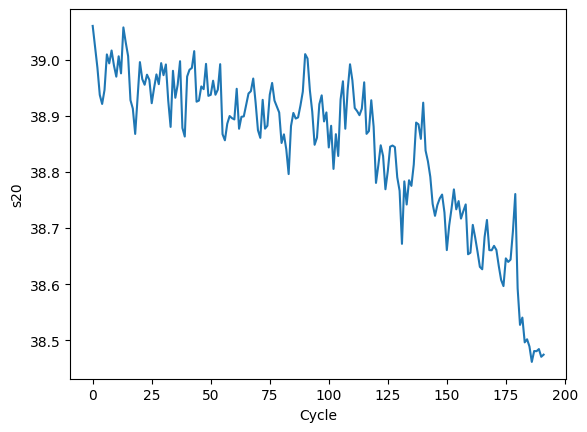

In [ ]:
plt.plot(train_df[train_df['id']==1]['s20'])
plt.xlabel('Cycle')
plt.ylabel('s20')
plt.show()

<Axes: >

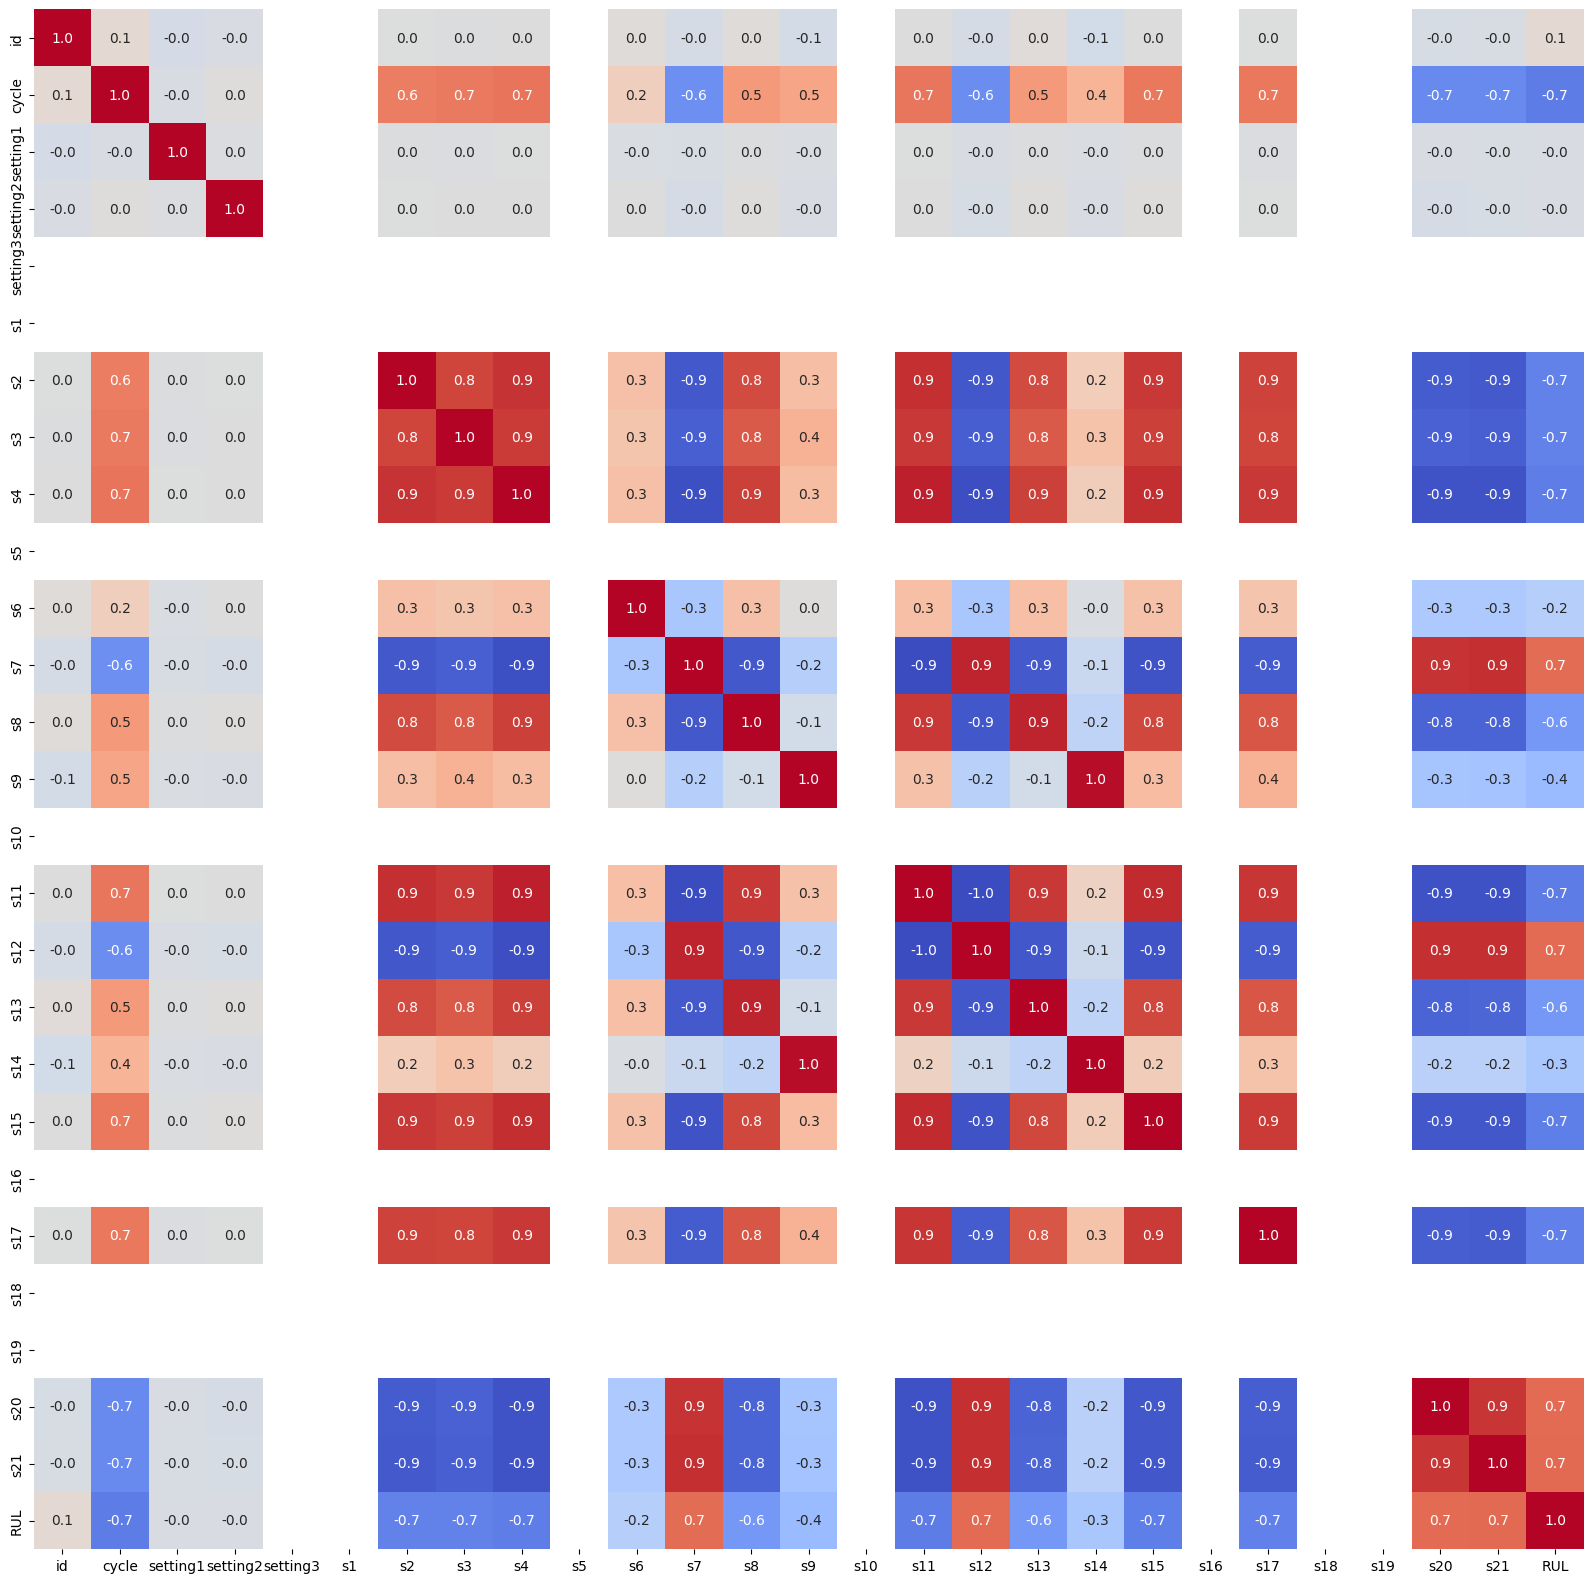

In [ ]:
plt.figure(figsize = (20,20))
sns.heatmap(train_df.corr(),annot=True, cbar=False, cmap='coolwarm', fmt='.1f')

In [ ]:
sequence_length = 30
# Define a function to reshape features
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [ ]:
# Select feature columns
sensor_cols = ['s' + str(i) for i in range(1, 22) if i not in [1, 5, 10, 16, 18, 19]]
sequence_cols = ['setting' + str(i) for i in range(1, 3)]
sequence_cols.extend(sensor_cols)

# Generate sequences and convert to numpy array
seq_gen = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# Reshape seq_array to 2D
seq_array_2d = seq_array.reshape(-1, seq_array.shape[-1])

# Standardize the data
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
seq_array_2d = scaler.fit_transform(seq_array_2d)

# Reshape seq_array_2d back to (samples, time steps, features)
seq_array = seq_array_2d.reshape(seq_array.shape)

(17631, 30, 17)


In [ ]:
# Define a function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# Generate labels
label_gen = [gen_labels(train_df[train_df['id'] == id], sequence_length, ['RUL'])
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(17631, 1)

In [ ]:
# Define R2 score callback for Keras
def r2_keras(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())


### 模型結構

In [ ]:
# Learning Rate Scheduler
lr_schedule = CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    alpha=0.0
)

# Model Architecture
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

# Depthwise Separable Convolution Layer for Feature Extraction
model.add(SeparableConv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, nb_features)))
model.add(SeparableConv1D(filters=128, kernel_size=5, activation='relu'))
model.add(LayerNormalization())
model.add(MaxPooling1D(pool_size=2))  # Optional pooling


# LSTM Layers
model.add(Bidirectional(LSTM(units=120, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01), activation='tanh')))
model.add(Dropout(0.15))
model.add(Bidirectional(LSTM(units=60, return_sequences=False)))
model.add(LayerNormalization())
model.add(Dropout(0.25))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(units=nb_out))
model.add(Activation("linear"))  # Linear Activation for Regression Output

# Optimizer with Gradient Clipping
optimizer = Adam(learning_rate=lr_schedule, clipnorm=10)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae', 'mse'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)

# Model Training
history = model.fit(seq_array, label_array, epochs=100, batch_size=150, validation_split=0.05, verbose=2, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
112/112 - 14s - 128ms/step - loss: 8864.4219 - mae: 74.0822 - mse: 8860.8477 - val_loss: 7317.7603 - val_mae: 66.4994 - val_mse: 7314.9155
Epoch 2/100
112/112 - 4s - 35ms/step - loss: 6173.6440 - mae: 60.4683 - mse: 6171.3008 - val_loss: 4814.3296 - val_mae: 54.0170 - val_mse: 4812.4043
Epoch 3/100
112/112 - 2s - 17ms/step - loss: 4236.6973 - mae: 51.4948 - mse: 4235.0513 - val_loss: 3717.4126 - val_mae: 49.7576 - val_mse: 3716.0022
Epoch 4/100
112/112 - 2s - 14ms/step - loss: 2822.9255 - mae: 39.5741 - mse: 2821.2881 - val_loss: 1680.8337 - val_mae: 29.3283 - val_mse: 1678.9335
Epoch 5/100
112/112 - 2s - 14ms/step - loss: 1518.8575 - mae: 27.1429 - mse: 1516.9131 - val_loss: 1205.9196 - val_mae: 26.3509 - val_mse: 1203.9365
Epoch 6/100
112/112 - 2s - 22ms/step - loss: 1284.9934 - mae: 25.0429 - mse: 1282.9846 - val_loss: 1146.1310 - val_mae: 22.8465 - val_mse: 1144.0940
Epoch 7/100
112/112 - 3s - 23ms/step - loss: 1234.2251 - mae: 24.7057 - mse: 1232.1660 - val_loss: 1209.

In [ ]:
# Generate predictions for the test data
seq_array_test_last = [test_df[test_df['id'] == id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id'] == id]) >= sequence_length]
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Reshape to 2D & # Standardize the test data
seq_array_test_last_2d = seq_array_test_last.reshape(-1, seq_array_test_last.shape[-1])
seq_array_test_last_2d = scaler.transform(seq_array_test_last_2d)

# Reshape back to 3D
seq_array_test_last = seq_array_test_last_2d.reshape(seq_array_test_last.shape)

# Make predictions
y_pred_test = model.predict(seq_array_test_last)

# Create a DataFrame for the predictions and save to a CSV file
test_set = pd.DataFrame(y_pred_test, columns=['RUL'])
# 到整數+比零小的話為0
test_set['RUL'] = test_set['RUL'].round().clip(lower=0)
test_set.index = test_set.index + 1
test_set.to_csv('output.csv', index_label='id')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
